In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt

# '"text.usetex": True' causes  runtime errors when plotting.
plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "sans-serif",
#    "font.sans-serif": "Computer Modern",
    "font.size": 22})


#import numpy as np
from scipy import integrate as integrate
import math

from astropy.cosmology import Planck18 # Planck 2018 cosmology, see https://arxiv.org/abs/1807.06209
import astropy.units as au # Astrophysical units

import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

import jax
import jax_cosmo as jc
import jax.numpy as np

print("JAX version:", jax.__version__)
print("jax-cosmo version:", jc.__version__)

Using CAMB 1.4.0 installed at /home/carter/.venv.camb/lib/python3.10/site-packages/camb
JAX version: 0.4.12
jax-cosmo version: 0.1.0


In [2]:
# Useful constants
H0_INV = 2997.8 #h^{-1} Mpc
GAMMA_INT = .2

In [3]:
def convert_cosmology_camb_to_jc(pars : camb.CAMBparams):
    h = pars.H0/100
    results = camb.get_results(pars)
    sig8 = results.get_matter_transfer_data().sigma_8
    pars_jc = jc.Cosmology(pars.omch2/h**2, pars.ombh2/h**2, h,
                           pars.InitPower.ns, sig8, pars.omk,
                           pars.DarkEnergy.w, pars.DarkEnergy.wa)
    return pars_jc

In [4]:
def get_Cl_errorbars(ell_bins, f_sky, cl_index, probes, cosmoParams, nz):
    dell = ell_bins[1:]-ell_bins[:-1]
    ell_sample = (ell_bins[1:]*ell_bins[:-1])**.5
    Cell_sample = jc.angular_cl.angular_cl(cosmoParams, ell_sample, probes)[cl_index]
    shotnoise = GAMMA_INT**2/nz.gals_per_steradian
    sigma_cl = (2/((2*ell_sample+1)*f_sky))**.5*(Cell_sample + shotnoise)
    sigma_cl = sigma_cl*ell_sample*(ell_sample+1)/(2*math.pi)
    errorbars = np.array([ell_sample, Cell_sample, sigma_cl, ell_sample[:]-ell_bins[:-1], ell_bins[1:]-ell_sample[:]])
    return errorbars

In [5]:
nzs_DESY3 = [jc.redshift.smail_nz(1.5, 10, .4, gals_per_arcmin2 = .15),
             jc.redshift.systematic_shift(jc.redshift.smail_nz(3.5, 10, .5),.02, gals_per_armin2 = .107),
             jc.redshift.systematic_shift(jc.redshift.smail_nz(3.5, 10, .5), .18, gals_per_armin2 = .109),
             jc.redshift.systematic_shift(jc.redshift.smail_nz(3.5, 10, .5), .33, gals_per_armin2 = .146),
             jc.redshift.systematic_shift(jc.redshift.smail_nz(4.5, 10, .5), .45, gals_per_armin2 = .106),
             jc.redshift.systematic_shift(jc.redshift.smail_nz(3.5, 10, .5), .55, gals_per_armin2 = .1)]
probes = [jc.probes.WeakLensing(nzs_DESY3)]
ell = np.logspace(1,4, 100)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Text(0.5, 1.0, 'DES Redshift Bins')

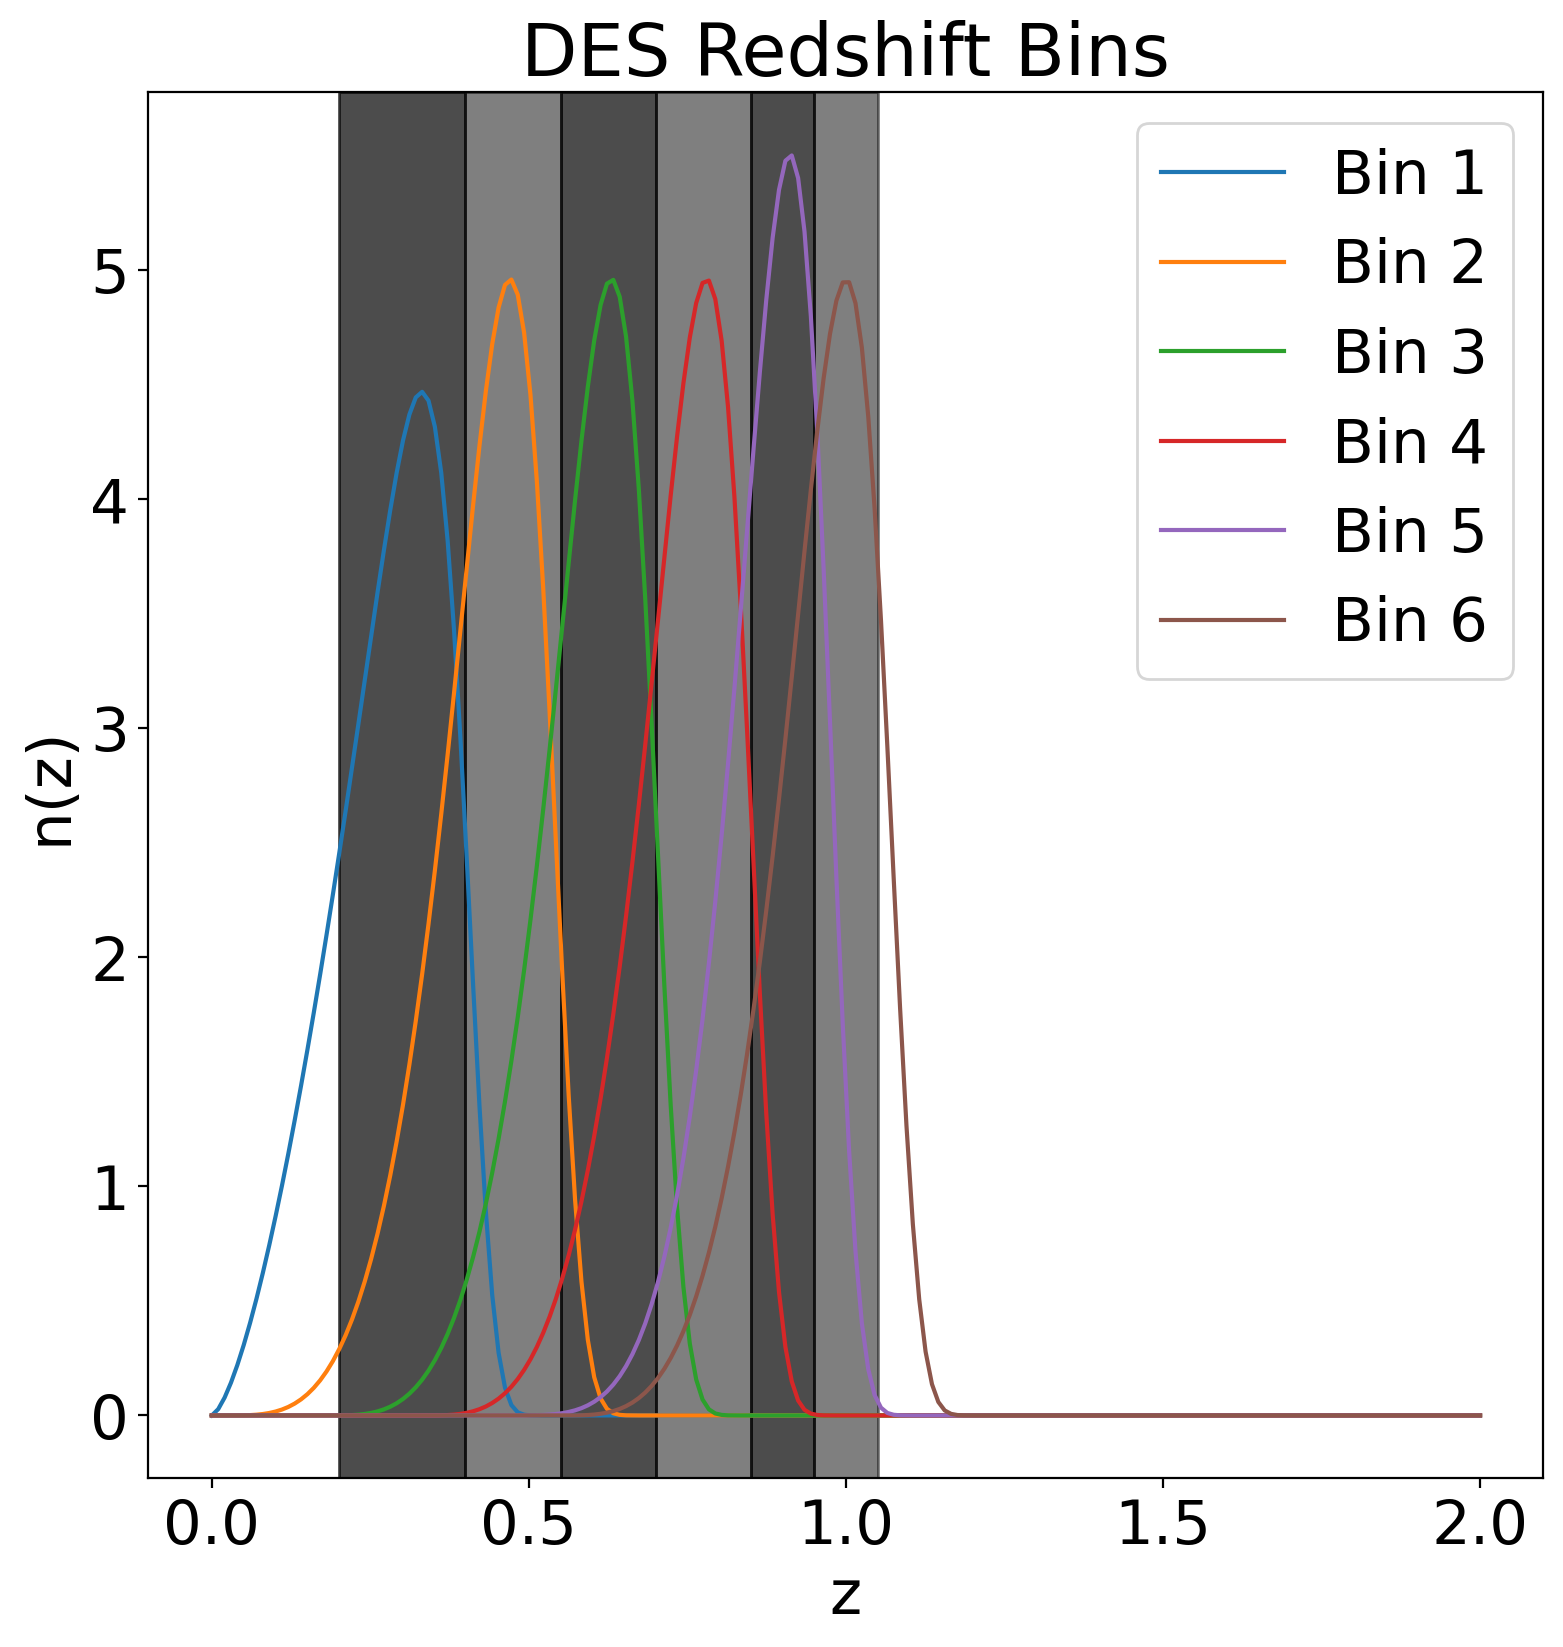

In [6]:
#Plot redshift bins.
z = np.linspace(0,2,200)
zbins = [.2,.4,.55,.7,.85,.95,1.05]
plt.figure(figsize= (9,9))
for i in np.arange(len(nzs_DESY3)):
    plt.plot(z, nzs_DESY3[i](z), label = r'Bin '+str(i+1))
for i in np.arange(len(zbins)-1):
    if i%2==0:
        plt.axvspan(zbins[i], zbins[i+1], color ='k', alpha=.7)
    else:
        plt.axvspan(zbins[i], zbins[i+1], color ='k', alpha=.5)
plt.legend()
plt.xlabel('z')
plt.ylabel('n(z)')
plt.title('DES Redshift Bins')

In [7]:
cosmo_fid = jc.Planck15(gamma = .55)
pars_gamma_1 = jc.Planck15(gamma = .68)

ell = np.arange(10,1e5)
cls_fiducial = jc.angular_cl.angular_cl(cosmo_fid, ell, probes)
cls_1 = jc.angular_cl.angular_cl(pars_gamma_1, ell, probes)

/home/carter/.venv.camb/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


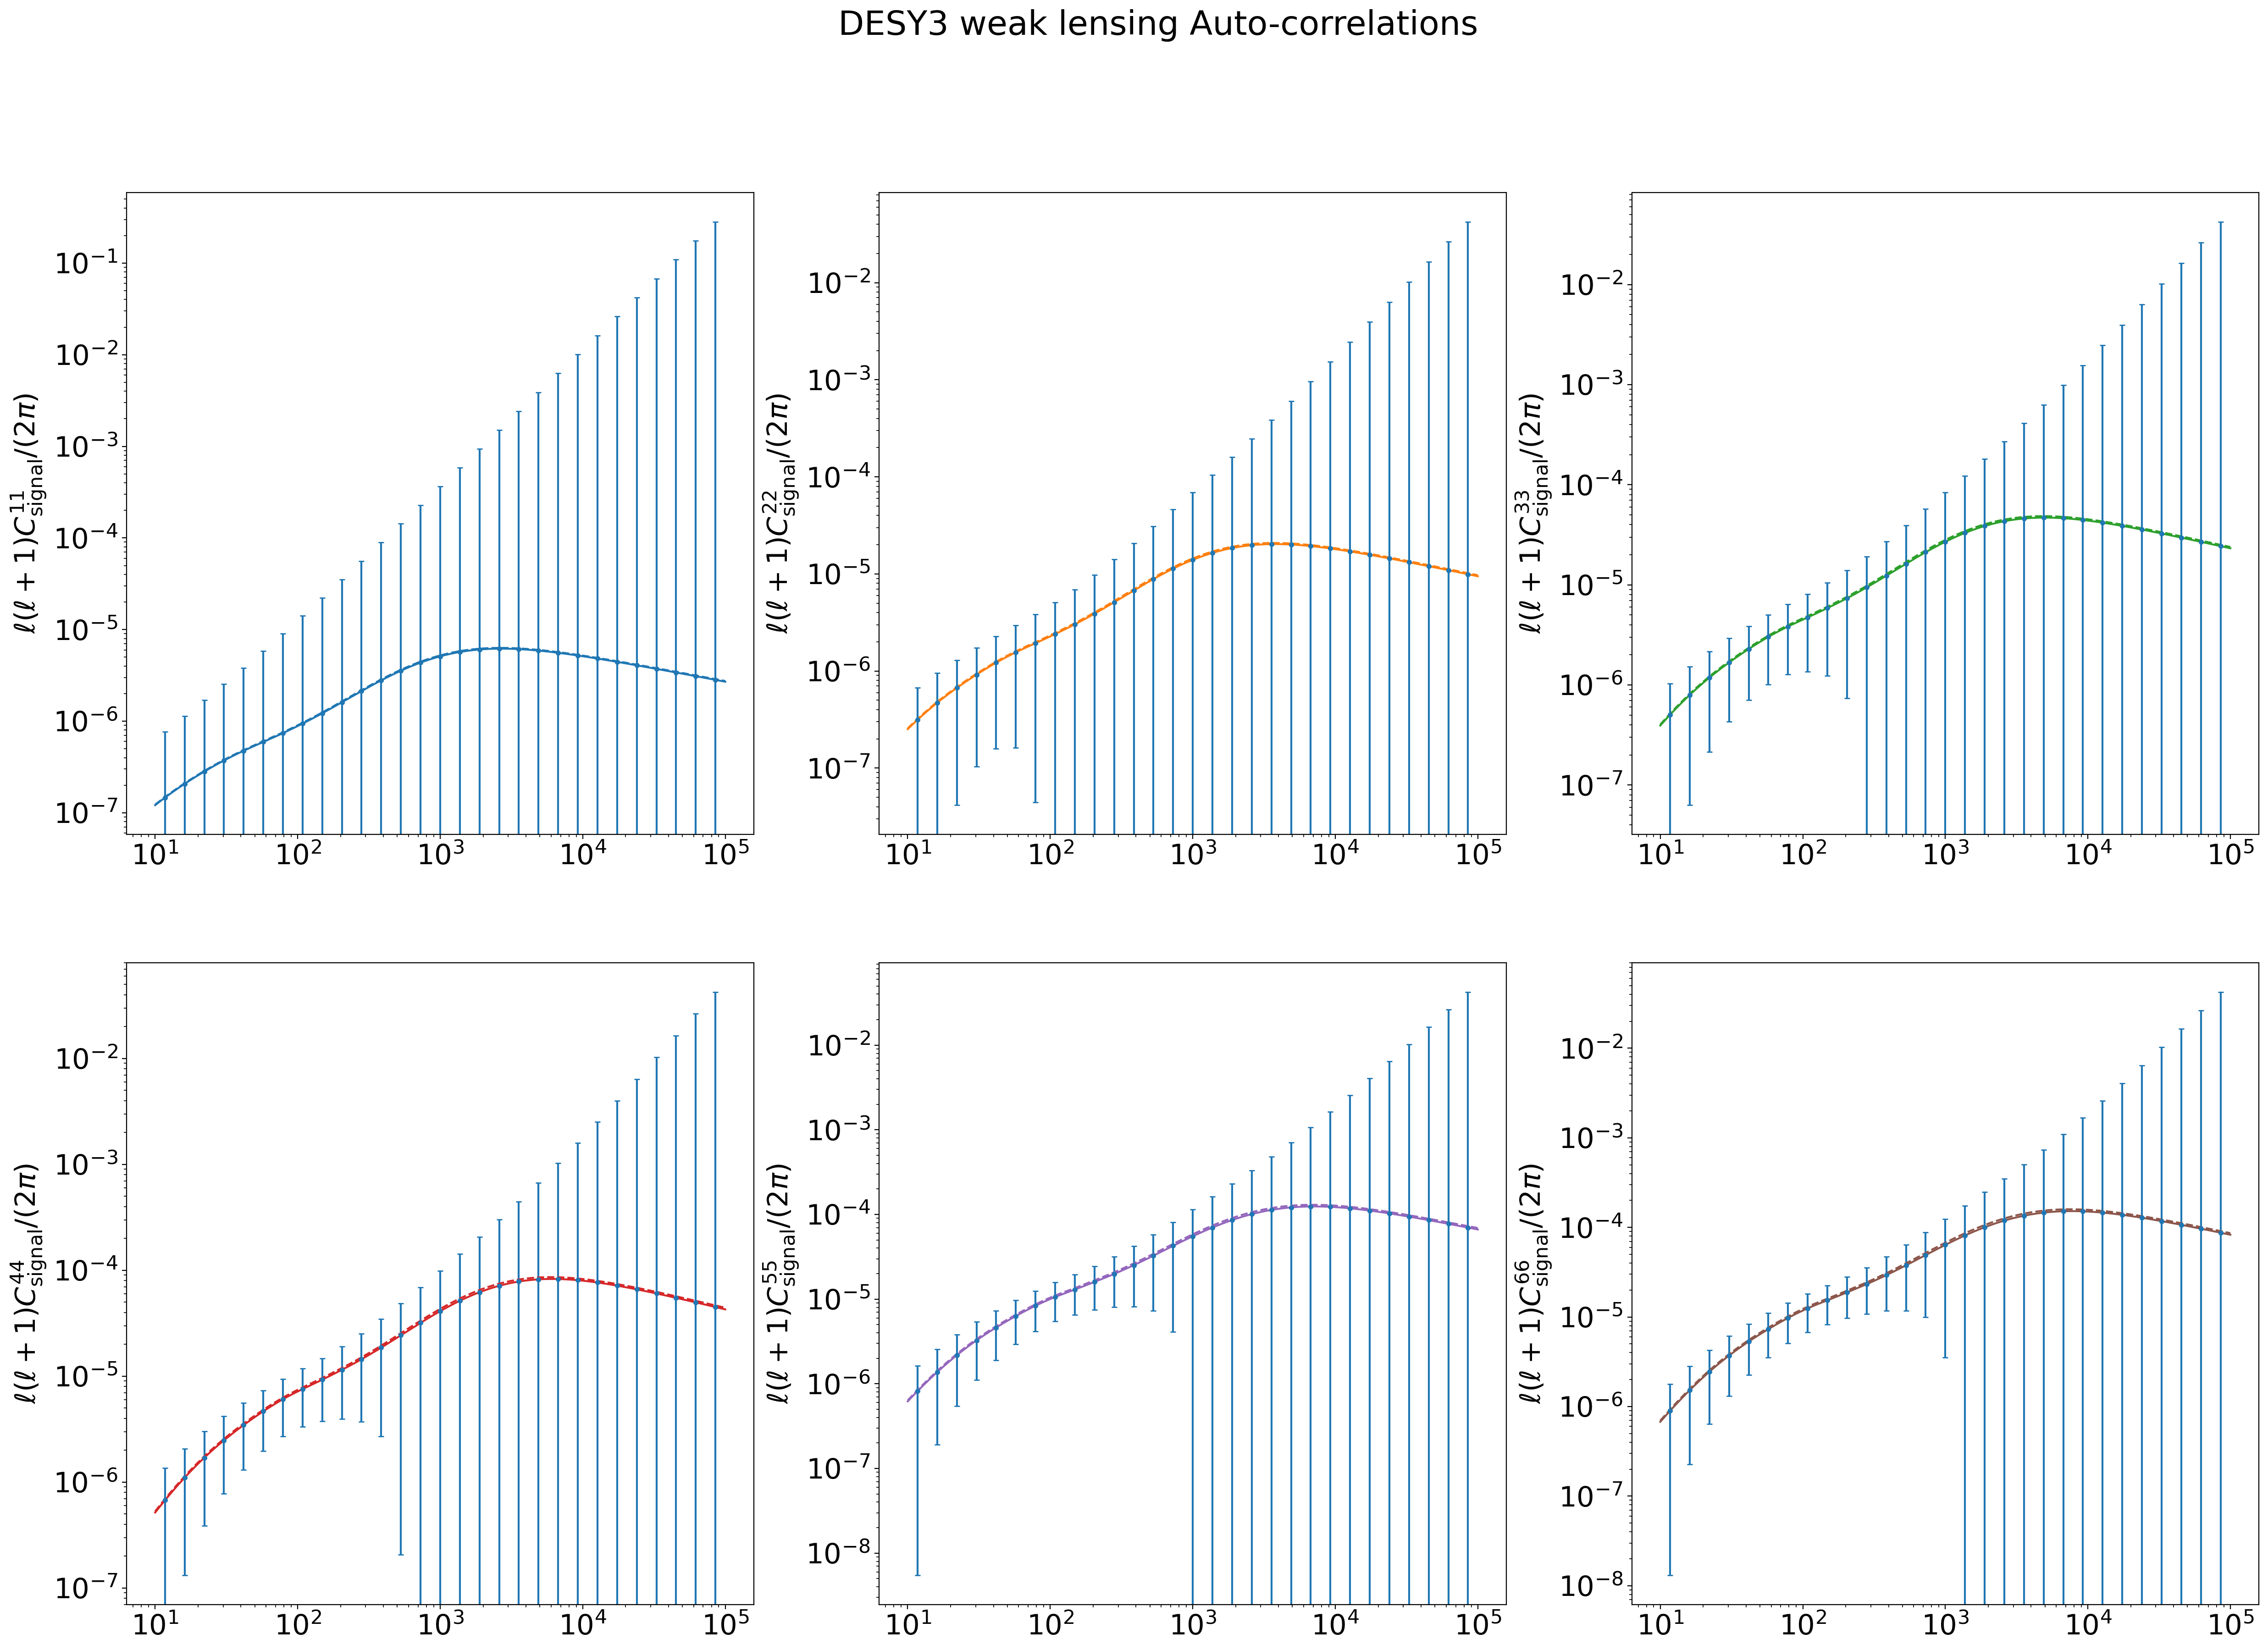

In [8]:
autocorr_indices = [0,6,11,15,18,20]
ell_bins = np.logspace(1,5,num=30)
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
fig, ax = plt.subplots(2,3, figsize=(30,20))

fig.suptitle('DESY3 weak lensing Auto-correlations')

for i in np.arange(len(autocorr_indices)):
    ax[min(1,i-i%3),i%3].loglog(ell, cls_fiducial[autocorr_indices[i]]*ell*(ell+1)/(2*math.pi), label=str(i+1)+str(i+1), color=colors[i])
    errorbars = get_Cl_errorbars(ell_bins, .1, autocorr_indices[i], probes, cosmo_fid, nzs_DESY3[i])
    ax[min(1,i-i%3),i%3].errorbar(errorbars[0], errorbars[1]*errorbars[0]*(errorbars[0]+1)/(2*math.pi), yerr=errorbars[2],
                capsize=2, marker='.', ls='none')
    ax[min(1,i-i%3),i%3].loglog(ell, cls_1[autocorr_indices[i]]*ell*(ell+1)/(2*math.pi), label=str(i+1)+str(i+1), ls='--', color=colors[i])
    ax[min(1,i-i%3),i%3].set_ylabel(r'$\ell(\ell+1)C_\mathrm{signal}^{%s%s}/(2\pi)$'%(str(i+1),str(i+1)))

In [10]:
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo_fid, ell_bins, probes, sparse = True)

/home/carter/.venv.camb/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [11]:
params = np.array([cosmo_fid.gamma, cosmo_fid.Omega_b, cosmo_fid.Omega_c])
def mean_fn_gamma_omega_m(p):
    cosmo = jc.Planck15(gamma=p[0], Omega_b=p[1]+p[2]) # Is this actually a valid way of doing a forecast for Omega_m?
    #It seems like I'm really using Omega_b as the parameter, esp. since the constant Omega_c will fall out when taking the derivative.
    m = jc.angular_cl.angular_cl(cosmo, ell_bins, probes)
    return m.flatten()
jac_mean_gamma_omega_m = jax.jit(jax.jacfwd(mean_fn_gamma_omega_m))

In [12]:
dmu = jac_mean_gamma_omega_m(params)

In [13]:
F = jc.sparse.dot(dmu.T, jc.sparse.inv(cov), dmu)

In [14]:
from matplotlib.patches import Ellipse
def plot_contours_slow(fisher, pos, ax, dchi2 = 2.3, xlim = (.5,.6), ylim = (.25,.35),
                  color = 'red', label=''):
    G11 = fisher[0,0]
    G12 = fisher[0,1]
    G22 = fisher[1,1]
    x = np.linspace(xlim[0], xlim[1], 1000)
    y = np.linspace(ylim[0], ylim[1], 1000)
    x,y = np.meshgrid(x,y)
    func = G11*(x-pos[0])**2+2*G12*(x-pos[0])*(y-pos[1])+G22*(y-pos[1])**2-dchi2
    ax.contour(x,y,func, [0], colors=[color], label=label)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

/tmp/ipykernel_14533/2714710520.py:11: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(x,y,func, [0], colors=[color], label=label)


Text(0, 0.5, '$\\Omega_m$')

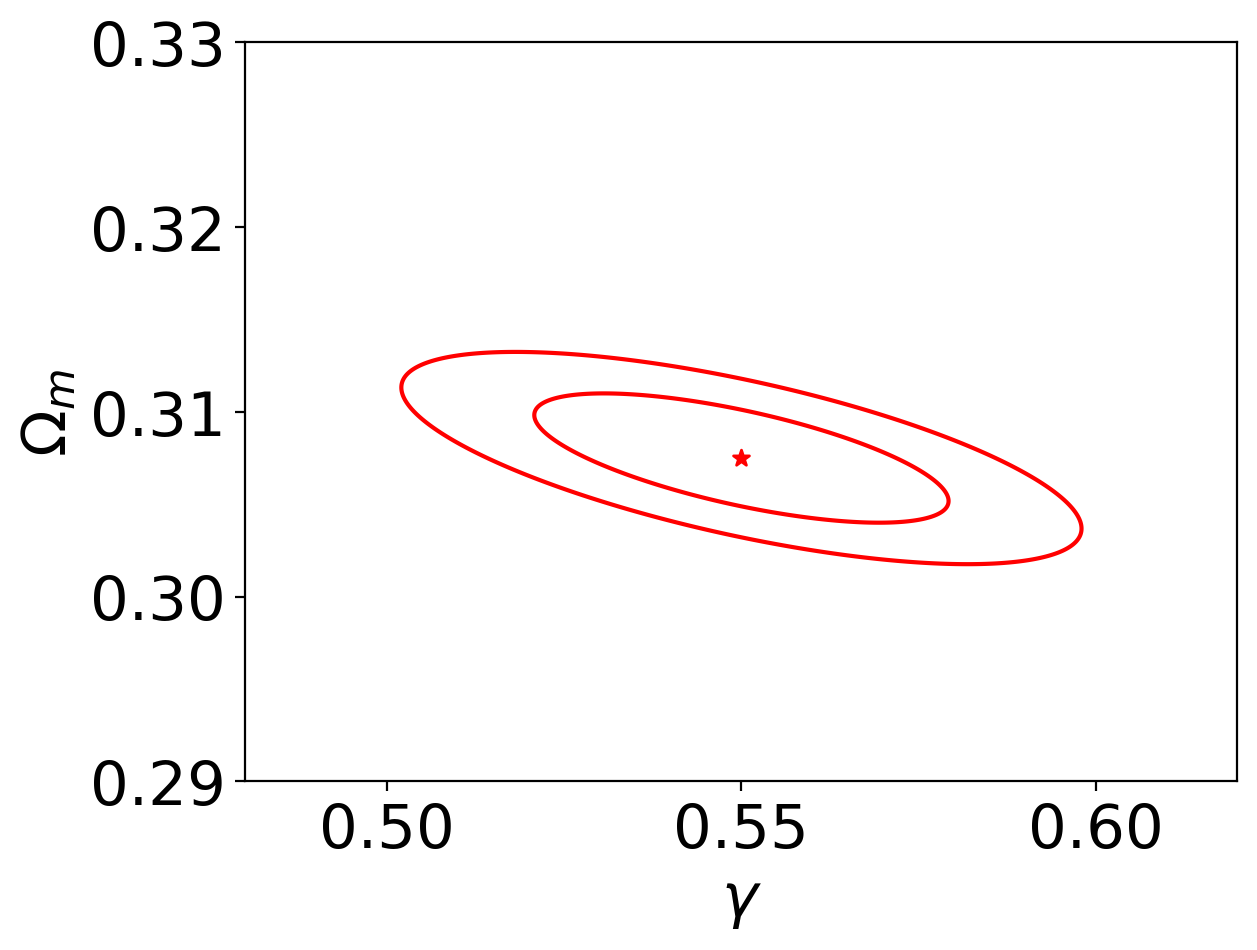

In [18]:
fig,ax = plt.subplots(1,1)
plot_contours_slow(F, [cosmo_fid.gamma, cosmo_fid.Omega_m], ax, xlim = (.48,.62), ylim = (.29,.33), dchi2 = 2.3)
plot_contours_slow(F, [cosmo_fid.gamma, cosmo_fid.Omega_m], ax, xlim = (.48,.62), ylim = (.29,.33), dchi2 = 6.2)
ax.scatter(cosmo_fid.gamma, cosmo_fid.Omega_m, color='red', marker='*')
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\Omega_m$')